In [1]:
import sys
import numpy as np
import math
import ceo
import matplotlib.pyplot as plt
import IPython
%matplotlib inline
import scipy.io as sio
import os.path
import datetime
import csv
import commands

In [2]:
sys.stdout = open('Phasing_Ctrl.log','wb')

In [2]:
from Phasing_in_AO_mode_params import *

pupil sampling: 481 pixel
number of SH SAs across pupil: 60
number of SH pixels per SA: 8


In [3]:
## GENERIC STUFF:
tid = ceo.StopWatch()
CEO_git_commit = commands.getoutput("git rev-parse --verify --short HEAD")
VISU=True

# Initialize Telescope and Turbulence

In [4]:
# Telescope
if simul_onaxis_AO==True:
    if onaxis_AO_modes==u"Karhunen-Loeve":
        gmt = ceo.GMT_MX(D, nPx, M2_mirror_modes=onaxis_AO_modes, M2_N_MODE=M2_n_modes)
    elif onaxis_AO_modes==u"zernike":
        gmt = ceo.GMT_MX(D, nPx, M2_mirror_modes=onaxis_AO_modes, 
                         M2_radial_order=M2_radial_order)
        
    # Telescope to be used for CL IM calibrations
    gmt0 = ceo.GMT_MX(D, nPx, M2_mirror_modes=u"zernike", M2_radial_order=M2_radial_order)
    
else:
    gmt = ceo.GMT_MX(D, nPx)

p = D/(nPx-1)

In [5]:
# Turbulence parameters:
if simul_turb == True:
    atm = ceo.JGmtAtmosphere(jsonfile=atm_fname)
    r0 = atm.r0
    L0 = atm.L0
    print r0, L0

@(ceo.JGmtAtmosphere)>
{
  "pupil size": 26.0,
  "r0": 0.15,
  "field-of-view [arcmin]": 20,
  "filename": "/mnt/bins/gmtAtmosphereL060.bin",
  "L0": 60,
  "duration": 15,
  "pupil sampling": 346,
  "time sampling": 20
}
0.15000000596 60.0


# Initialize Simplified NGAO/LTAO system
The simplified LTAO system comprises:
1. **on-axis geometrical SH sensor** with 60x60 sub-apertures controlling 300 KL modes / M2 segment

The simplified NGAO system comprises:
1. **on-axis geometrical SH sensor** with 60x60 sub-apertures controlling 300 KL modes / M2 segment
2. **on-axis idealized SPP sensor** controlling segment piston.

In [5]:
#---- ON-AXIS AO SH WFS:
if simul_onaxis_AO == True:
    d = D/nLenslet
    if SHtype == 'diff':
        wfs = ceo.ShackHartmann(nLenslet, n, d, N_PX_IMAGE=2*(n+1), N_GS=1)
    elif SHtype == 'geom':
        wfs = ceo.GeometricShackHartmann(nLenslet, d, N_GS=1)
    gs = ceo.Source("R",zenith=0.,azimuth=0.,
                    rays_box_size=D, rays_box_sampling=nPx, rays_origin=[0.0,0.0,25])

    # Calibrate SH (valid SAs, slope null vector)
    gs.reset()
    gmt.reset()
    gmt.propagate(gs)
    wfs.calibrate(gs,sh_thr)

    if SHtype == 'diff':
        sh_fov = wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/wfs.BIN_IMAGE

        if VISU == True:
            plt.imshow(wfs.flux.host(shape=(nLenslet,nLenslet)).T,interpolation='none', origin='lower')

        print "pupil sampling: %d pixel"%nPx
        print "number of SH SAs across pupil: %d"%nLenslet
        print "number of SH pixels per SA: %d"%n
        print "SH Pixel scale: %.3farcsec"%(wfs.pixel_scale_arcsec)
        print "SH Field of view: %.3farcsec"%(sh_fov)

In [6]:
# Calibrate M2 KLs - SH Interaction Matrix and Reconstructor
if simul_onaxis_AO == True:
    
    fname = 'IM_SH'+SHtype+\
    '_'+onaxis_AO_modes+'_nmode'+str(gmt.M2.modes.n_mode)+'_SHthr%1.1f.npz'%sh_thr

    z_first_mode = 1   #include segment piston (to be removed later....)
    Zstroke = 10e-9 #m rms

    if os.path.isfile(fname) == False:    
        D_M2_MODES = gmt.calibrate(wfs, gs, mirror="M2", mode=onaxis_AO_modes, stroke=Zstroke, first_mode=z_first_mode)
        np.savez(fname, D_M2=D_M2_MODES, first_mode=z_first_mode, Stroke=Zstroke)
    else:
        print 'Reading file: '+fname
        ftemp = np.load(fname)
        D_M2_MODES = ftemp.f.D_M2
        ftemp.close()

    nall = (D_M2_MODES.shape)[1]  ## number of zernike DoFs calibrated
    n_mode = nall/7

    print 'AO SH WFS - M2 Segment Modal IM:'
    print D_M2_MODES.shape

Reading file: IM_SHgeom_Karhunen-Loeve_nmode300_SHthr0.2.npz
AO SH WFS - M2 Segment Modal IM:
(4176, 2093)


SPP - SH IM:
___ M2 ___ (segment piston)
Segment #:1 2 3 4 5 6 7 
------------
SPP - SPS IM:
___ M2 ___ (segment piston)
Segment #:1 2 3 4 5 6 7 
------------


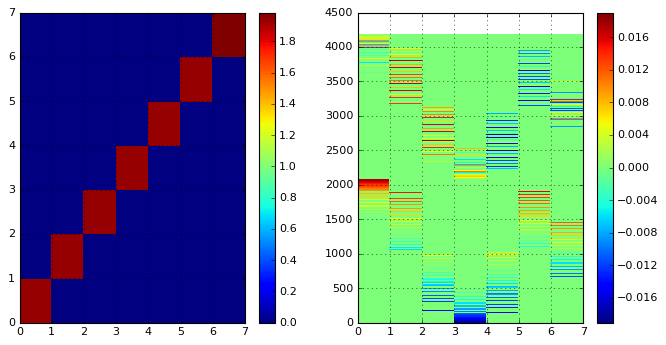

In [7]:
if simul_onaxis_AO == True and AOtype == 'NGAOish':
    
    onps = ceo.IdealSegmentPistonSensor(gs, D, nPx, segment='full')
    gs.reset()
    gmt.reset()
    gmt.propagate(gs)
    onps_signal_ref = onps.piston(gs).ravel() #[0:6] # reference signal
    
    #-----> SH - M2 segment piston IM
    print("SPP - SH IM:")
    PSstroke = 200e-9 #m
    D_M2_PS_sh = gmt.calibrate(wfs, gs, mirror="M2", mode="segment piston", stroke=PSstroke)

    #-----> Ideal SPS - M2 segment Zernikes IM
    D_M2_MODES_PSideal = np.zeros((7,nall))    

    #-----> Ideal SPS - M2 segment piston IM
    print("SPP - SPS IM:")
    PSstroke = 50e-9 #m
    D_M2_PSideal = gmt.calibrate(onps, gs, mirror="M2", mode="segment piston", stroke=PSstroke)
        
    if VISU == True:
        fig, (ax1,ax2) = plt.subplots(ncols=2)
        fig.set_size_inches(10,5)
        imm = ax1.pcolor(D_M2_PSideal)
        ax1.grid()
        fig.colorbar(imm, ax=ax1)#, fraction=0.012)       

        imm1 = ax2.pcolor(D_M2_PS_sh)
        ax2.grid()
        fig.colorbar(imm1)

In [8]:
#----> Create super-merger IM for "simplified NGAO control"
# DoFs: segment Zernikes (Z2->Zx), segment Piston
# Sensors: on-axis SH WFS, on-axis idealized Piston Sensor
if simul_onaxis_AO==True:
    
    if AOtype == 'NGAOish':
    
        D_AO_SH = np.concatenate((D_M2_MODES, D_M2_PS_sh), axis=1)
        print 'Merged (seg Z & Pist) - SH IM:'
        print D_AO_SH.shape

        D_AO_PS = np.concatenate((D_M2_MODES_PSideal, D_M2_PSideal), axis=1)
        print 'Merged (seg Z & Pist) - Ideal SPS IM:'
        print D_AO_PS.shape

        D_AO = np.concatenate((D_AO_SH, D_AO_PS), axis=0)
        print 'NGAO-ish super-merged IM:'
        print D_AO.shape

    elif AOtype == 'LTAOish':
        D_AO = D_M2_MODES
        print 'LTAOish IM:'
        print D_AO.shape

Merged (seg Z & Pist) - SH IM:
(4176, 2100)
Merged (seg Z & Pist) - Ideal SPS IM:
(7, 2100)
NGAO-ish super-merged IM:
(4183, 2100)


Condition number: 36298.111475


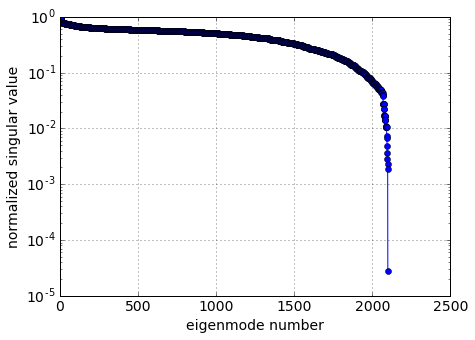

In [10]:
if simul_onaxis_AO==True:

    print 'Condition number: %f'%np.linalg.cond(D_AO)
    Uz, Sz, Vz =np.linalg.svd(D_AO)

    fig, ax = plt.subplots()
    fig.set_size_inches(7,5)

    ax.semilogy(Sz/np.max(Sz), 'o-', )
    ax.grid()
    ax.tick_params(labelsize=14)
    ax.set_xlabel('eigenmode number', fontsize=14)
    ax.set_ylabel('normalized singular value', fontsize=14)
    #ax.set_xlim([2400,2500])

In [11]:
#--- Compute the Rec Matrix (with SVD filtering)
if simul_onaxis_AO==True:

    R_AO = np.linalg.pinv(D_AO, rcond=1.0e-3)
    print 'AO SH WFS - M2 Segment Modal Rec:'
    print R_AO.shape

AO SH WFS - M2 Segment Modal Rec:
(2100, 4183)


# Initialize Phasing System

In [19]:
#AGWS Guide Star locations
if simul_SPS==True:
    if asterism_type == 'Dummy':
        zenith_angle_agws  = np.ones(N_GS_PS)*alpha_ps*math.pi/180/3600 # in radians
        azimuth_angle_agws = np.arange(N_GS_PS)* (360.0/N_GS_PS) * (math.pi/180) # in radians
        mag = np.ones(N_GS_PS)*mag

    elif asterism_type == 'Besancon_GP':

        _asterism_zenith = []
        _asterism_azimuth = []
        _asterism_magnitude = []
        _asterism_Jmag = []

        with open('asterisms_phasing.txt', 'rb') as csvfile:
            asterisms = csv.reader(csvfile)
            for row in asterisms:
                _asterism_zenith.append( float(row[0])*ceo.constants.ARCMIN2RAD )
                _asterism_azimuth.append( float(row[1]) )
                _asterism_magnitude.append( float(row[2]) )
                _asterism_Jmag.append( float(row[3]) )

        asterism_id = np.load('asterism_id.npy')
        asterism_id = int(asterism_id.tolist())
        print "Asterism ID: %d"%asterism_id

        asterism_zenith = np.array(_asterism_zenith[asterism_id*3:(1+asterism_id)*3])
        asterism_azimuth = np.array(_asterism_azimuth[asterism_id*3:(1+asterism_id)*3])
        asterism_magnitude = np.array(_asterism_magnitude[asterism_id*3:(1+asterism_id)*3])
        asterism_Jmag = np.array(_asterism_Jmag[asterism_id*3:(1+asterism_id)*3])

        ordmag = (np.argsort(asterism_Jmag))
        mag = (asterism_Jmag[ordmag])[0:3]
        zenith_angle_agws = (asterism_zenith[ordmag])[0:3]
        azimuth_angle_agws = (asterism_azimuth[ordmag])[0:3]
        
    elif asterism_type == 'Besancon_GP_AB':
        
        _asterism_X = []
        _asterism_Y = []
        _asterism_Jmag = []

        with open('agws_sps_aster.txt', 'rb') as csvfile:
            asterisms = csv.reader(csvfile)
            headers = asterisms.next()
            for row in asterisms:
                _asterism_X.append(   np.array((float(row[0]),float(row[3]),float(row[6]))))
                _asterism_Y.append(   np.array((float(row[1]),float(row[4]),float(row[7]))))
                _asterism_Jmag.append(np.array((float(row[2]),float(row[5]),float(row[8]))))
            
        asterism_zenith = np.sqrt(np.array([X**2 for X in _asterism_X]) + \
                                  np.array([Y**2 for Y in _asterism_Y])).T * ceo.constants.ARCSEC2RAD
        
        asterism_azimuth = np.arctan2( np.array([Y for Y in _asterism_Y]), 
                                       np.array([X for X in _asterism_X])).T

        asterism_Jmag = np.array(_asterism_Jmag).T
        nast= asterism_Jmag.shape[1]
        
        dummy, badast = np.where( asterism_Jmag == 0)
        goodast = list(set(range(nast)) - set(badast.tolist()))
        asterism_zenith  = asterism_zenith[:,goodast]
        asterism_azimuth = asterism_azimuth[:,goodast]
        asterism_Jmag = asterism_Jmag[:,goodast]
        nast= asterism_Jmag.shape[1]
        
        asterism_id = np.load('asterism_id.npy')
        asterism_id = int(asterism_id.tolist())
        print "Asterism ID: %d"%asterism_id
        
        mag = asterism_Jmag[:,asterism_id]
        zenith_angle_agws  =  asterism_zenith[:,asterism_id]
        azimuth_angle_agws = asterism_azimuth[:,asterism_id]
        
    print("Selected asterism: \nmag(J) Zenith(')  Azimuth(deg)")
    for x in range(N_GS_PS): 
        print("%3.2f \t  %1.2f \t    %3.1f"%(mag[x], zenith_angle_agws[x]*ceo.constants.RAD2ARCMIN, 
                                                azimuth_angle_agws[x]*180/math.pi))

Asterism ID: 100
Selected asterism: 
mag(J) Zenith(')  Azimuth(deg)
12.34 	  9.85 	    -125.0
12.49 	  9.74 	    77.0
13.82 	  7.53 	    148.9


Number of SPS GS photons/s/m^2: 59792.9
Number of expected SPS GS photons [ph/s/m^2]: 61022.4
Number of SPS GS photons/s/m^2: 52077.5
Number of expected SPS GS photons [ph/s/m^2]: 53148.3
Number of SPS GS photons/s/m^2: 15298.5
Number of expected SPS GS photons [ph/s/m^2]: 15613.1


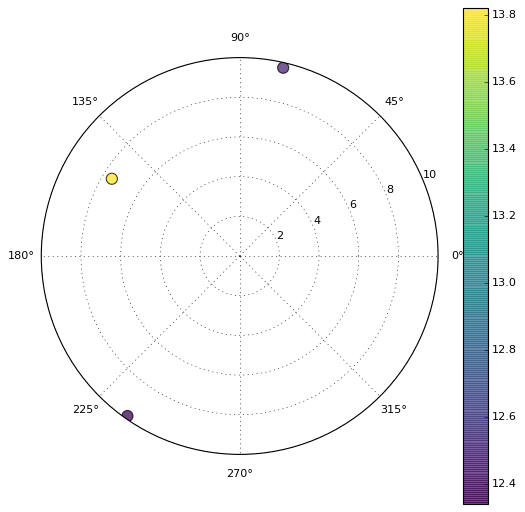

In [22]:
#---- OFF-AXIS DISPERSED FRINGE SENSORS:

if simul_SPS==True:
    gsps = ceo.Source(band, magnitude=mag,
                      zenith=zenith_angle_agws,azimuth=azimuth_angle_agws,
                      rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

    for x in range(gsps.N_SRC):
        print('Number of SPS GS photons/s/m^2: %.1f'%(gsps.nPhoton[x]))
        print('Number of expected SPS GS photons [ph/s/m^2]: %.1f'%(e0*10**(-0.4*mag[x])/PupilArea))
    
    if VISU==True:
        fig = plt.figure(figsize=(8,8))
        ax  = plt.subplot(111,polar=True)
        zen = gsps.zenith*ceo.constants.RAD2ARCMIN
        azi = gsps.azimuth
        c = ax.scatter(azi,zen,c=mag,s=100,cmap=plt.cm.viridis)
        ax.set_rmax(10)
        c.set_alpha(0.75)
        #c.set_clim([11,13.5])

        #c.set_edgecolor('None')
        plt.colorbar(c,ax=ax)

Size of DFS detector mask [pix]: 20


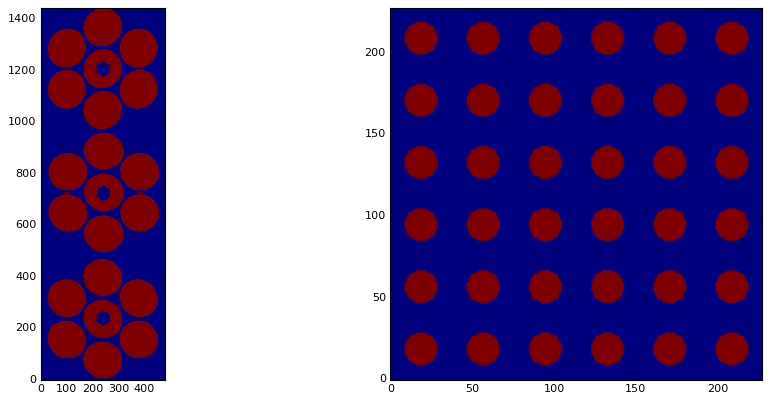

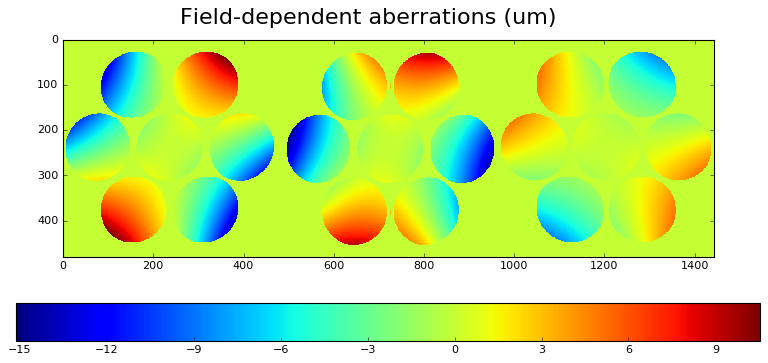

In [23]:
if simul_SPS==True:
    if SPStype == 'ideal':
        ps = ceo.IdealSegmentPistonSensor(gsps, D, nPx, segment='edge')
    elif SPStype == 'DFS':
        ps = ceo.DispersedFringeSensor(gmt.M1, gsps, dispersion=sps_dispersion,
                                       field_of_view=sps_fov, nyquist_factor=nyquist_factor)
        ps.lobe_detection = lobe_detection
        ps.camera.photoelectron_gain = throughput
        if sps_mask_size > 0: ps.init_detector_mask(sps_mask_size)

    # Calibrate DFS
    gmt.reset()
    gsps.reset()
    if SPStype == 'DFS':
        ps.INIT_ALL_ATTRIBUTES = True
        ps.calibrate(gsps,gmt)

    if VISU == True and SPStype == 'DFS':
        fig1, (ax1,ax2) = plt.subplots(ncols=2)
        fig1.set_size_inches((14,6))
        ax1.imshow(gsps.wavefront.amplitude.host().reshape((nPx*N_GS_PS,nPx)), origin='lower')
        ax2.imshow(ps.fft_mask.f.host().reshape((ps.camera.N_PX_FRAME,ps.camera.N_PX_FRAME)),
                   origin='lower')

    # Calibrate SPS reference vector (corresponding to field-dependent aberrations)
    gmt.reset()
    ps.reset()
    gsps.reset()
    gmt.propagate(gsps)
    ph_fda = gsps.phase.host(units='micron').T
    SPSmeas_ref = ps.piston(gsps).ravel()
    """ps.propagate(gsps)
    ps.camera.noiselessReadOut(SamplingTime)
    ps.fft()
    ps.process()
    SPSmeas_ref = ps.get_measurement()"""

    if eval_perf_sps==True:
        seg_pist_sps_ref = gsps.piston(where='segments', units_exponent=-9)

    if VISU == True:
        fig2, ax = plt.subplots()
        fig2.set_size_inches(20,5)
        fig2.suptitle('Field-dependent aberrations (um)', fontsize=20)
        imm = ax.imshow(ph_fda, interpolation='None')
        fig2.colorbar(imm, orientation='horizontal', shrink=0.6)

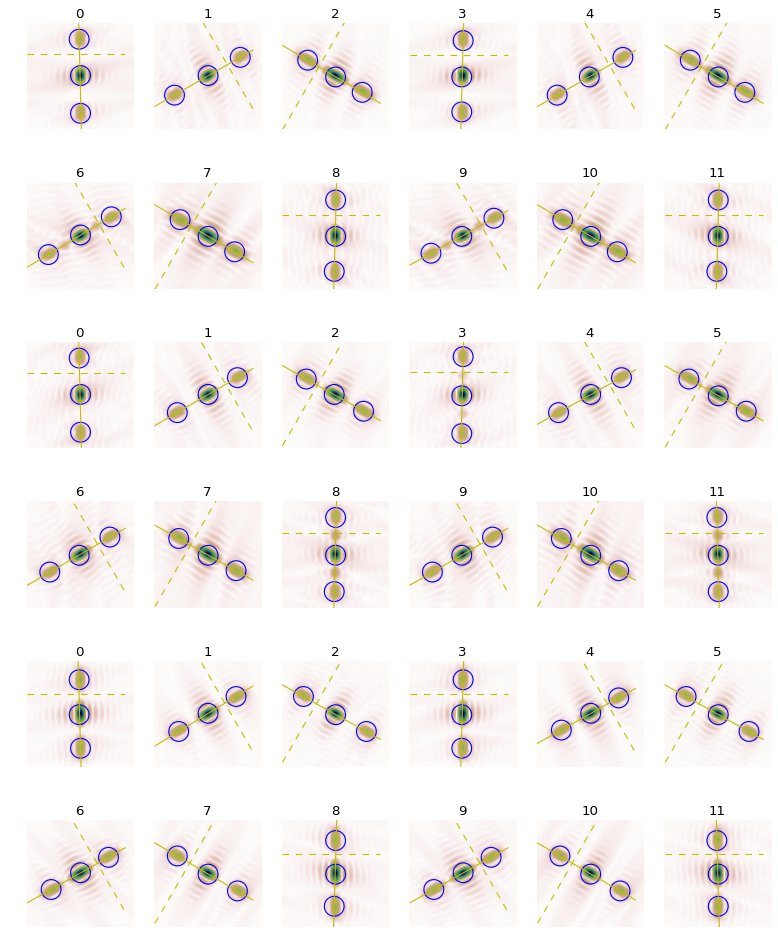

In [24]:
if simul_SPS==True:
    # Show DFS reference imagettes
    def show_sps_imagettes():
        dataCube = ps.get_data_cube(data_type='fftlet')

        fig, ax = plt.subplots(ps.camera.N_SIDE_LENSLET,ps.camera.N_SIDE_LENSLET)
        fig.set_size_inches((12,15))
        xvec = np.arange(0,ps.camera.N_PX_IMAGE,10)
        for k in range(gsps.N_SRC*12):
            (ax.ravel())[k].imshow(np.sqrt(dataCube[:,:,k]), cmap=plt.cm.gist_earth_r, origin='lower')
            (ax.ravel())[k].autoscale(False)
            if ps.INIT_ALL_ATTRIBUTES == True:
                (ax.ravel())[k].plot(xvec, xvec*ps.pl_m[k] + ps.pl_b[k], 'y')
                (ax.ravel())[k].plot(xvec, xvec*ps.pp_m[k] + ps.pp_b[k], 'y--')
                for pp in range(3):
                    c1 = plt.Circle((ps.blob_data[k,pp,1], ps.blob_data[k,pp,0]),radius=np.sqrt(2)*ps.blob_data[k,pp,2],
                                color='b', fill=False)
                    (ax.ravel())[k].add_patch(c1)
            (ax.ravel())[k].set_title('%d'%(k%12), fontsize=12)

        for k in range(ps.camera.N_SIDE_LENSLET**2):
            (ax.ravel())[k].axis('off')

    if VISU == True and SPStype == 'DFS':
        show_sps_imagettes()

## SPS Interaction Matrices calibration

In [18]:
#[D_M2_Z,D_M2_PS_sh, D_M2_Z_PSideal, D_M2_PSideal] = \
if simul_onaxis_AO==True and simul_SPS==True:
    gmt0.cloop_calib_init(D, nPx, onaxis_wfs_nLenslet=nLenslet, AOtype=AOtype)

Calibrating on-axis NGAOish AO system for closed-loop IntMat calibration
--------------------------------------------------------------------------

--> on-axis SH:
___ M2 ___ (zernike)
Segment #0: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #1: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #2: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #3: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #4: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #5: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #6: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
------------
___ M2 ___ (segment piston)
Segment #:1 2 3 4 5 6 7 
------------

--> on-axis SPS:
___ M2 ___ (zernike)
Segment #0: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #1: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #2: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #3: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #4: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #5: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #6: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
------------
AO SPS - M2 Segment Zerni

___ M1 ___ (segment piston)
Segment #:1 2 3 4 5 6 
------------
SPS - M1 Segment Piston IM:
(36, 6)


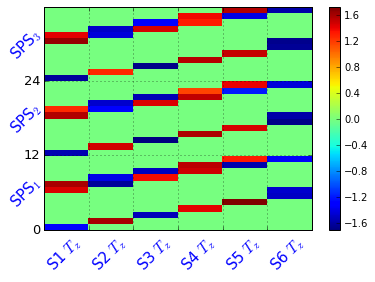

In [19]:
# Calibrate Segment Piston Sensor Interaction Matrix and Reconstructor
if simul_PS_control==True:
    PSstroke = 200e-9 #m
    
    if simul_onaxis_AO==False:
        D_M1_PS = gmt.calibrate(ps, gsps, mirror="M1", mode="segment piston", stroke=PSstroke)
    else:
        if AOtype == 'NGAOish':
            D_M1_PS = gmt0.calibrate(ps, gsps, mirror="M1", mode="segment piston", stroke=PSstroke)    
        elif AOtype == 'LTAOish':
            D_M1_PS = gmt0.calibrate(ps, gsps, mirror="M1", mode="segment piston", stroke=PSstroke, 
                                    closed_loop_calib=True)    
    
    #D_M1_PS = D_M1_PS[:,0:6]
    R_M1_PS = np.linalg.pinv(D_M1_PS)
    print 'SPS - M1 Segment Piston IM:'
    print D_M1_PS.shape
        

    if VISU == True:
        fig, ax = plt.subplots()
        fig.set_size_inches(6,4)
        imm = ax.pcolor(D_M1_PS*1e-6)  #in displaced pixels per micron
        ax.grid()
        ax.set_ylim([0,12*gsps.N_SRC])
        ax.set_xticklabels(['S1 $T_z$','S2 $T_z$','S3 $T_z$','S4 $T_z$','S5 $T_z$','S6 $T_z$'], ha='left',
                           fontsize=15, rotation=45, color='b')
        ax.set_yticks(np.arange(gsps.N_SRC)*12)
        ax.tick_params(axis='y', labelsize=13)
        for pp in range(gsps.N_SRC):
            ax.text(-0.4,pp*12+6,'SPS$_%d$'%(pp+1), rotation=45, ha='center', va='center', fontsize=15, color='b')
        fig.colorbar(imm)

___ M1 ___ (segment tip-tilt)
Segment #:1 2 3 4 5 6 7 
------------
SPS - FDSP IM:
(36, 14)


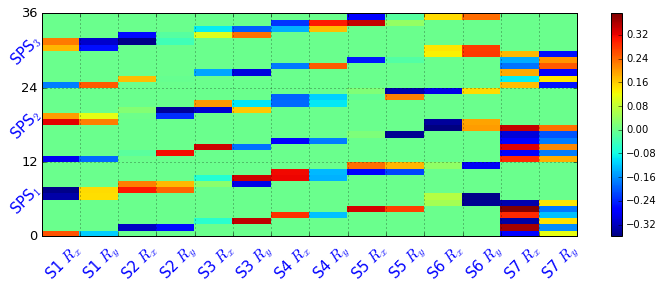

In [20]:
# Calibrate FSDP Interaction Matrix and Reconstructor
if simul_FDSP_control==True:
    TTstroke = 50e-3 #arcsec
    D_FDSP = gmt0.calibrate(ps, gsps, mirror="M1", mode="segment tip-tilt", stroke=TTstroke*math.pi/180/3600,
                          closed_loop_calib=True)
    #R_FDSP = np.linalg.pinv(D_FDSP)
    print 'SPS - FDSP IM:'
    print D_FDSP.shape

    if VISU == True:
        fig2, ax2 = plt.subplots()
        fig2.set_size_inches(12,4)

        #Rx and Ry are in radians. We want to show IM in microns RMS SURF of tilt
        #We found using DOS that a segment tilt of 47 mas is equivalent to 0.5 microns RMS of tilt on an M1 seg.
        AngleRadians_2_tiltcoeff = 0.5 / (47e-3*math.pi/180/3600) #angle in radians to microns RMS of tilt coeff

        imm = ax2.pcolor(D_FDSP/AngleRadians_2_tiltcoeff)  #in displaced pixels per microns RMS of M1 segment tilt
        ax2.grid()
        ax2.set_ylim([0,36])
        ax2.set_xticks(range(14))
        ax2.set_xticklabels(['S1 $R_x$','S1 $R_y$','S2 $R_x$','S2 $R_y$','S3 $R_x$','S3 $R_y$',
                            'S4 $R_x$','S4 $R_y$','S5 $R_x$','S5 $R_y$','S6 $R_x$','S6 $R_y$', 'S7 $R_x$','S7 $R_y$'],
                           ha='left', fontsize=15, rotation=45, color='b')
        ax2.set_yticks([0,12,24,36])
        ax2.tick_params(axis='y', labelsize=13)
        ax2.text(-0.4,6,'SPS$_1$', rotation=45, ha='center', va='center', fontsize=15, color='b')
        ax2.text(-0.4,18,'SPS$_2$', rotation=45, ha='center', va='center', fontsize=15, color='b')
        ax2.text(-0.4,30,'SPS$_3$', rotation=45, ha='center', va='center', fontsize=15, color='b')
        fig2.colorbar(imm)

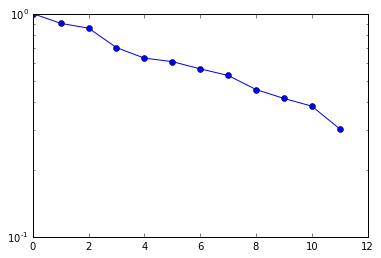

In [21]:
if simul_FDSP_control==True:

    D_FDSP = D_FDSP[:,0:12]
    UU, ss, VV = np.linalg.svd(D_FDSP, full_matrices=False)
    plt.semilogy(ss/np.max(ss), 'o-')
    
    R_FDSP = np.linalg.pinv(D_FDSP)

Merged SPS - PISTON IM:
(36, 18)
PIST Condition number: 2.141550
FDSP Condition number: 3.282480
Merged Condition number: 8.410713


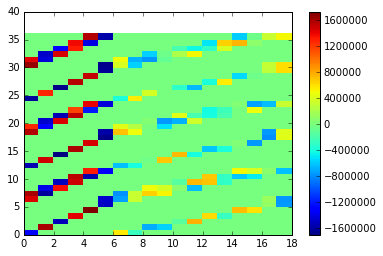

In [22]:
# Combine Interaction Matrices of M1 segment piston AND FDSP.
if simul_PS_control==True and simul_FDSP_control==True:
    D_PIST = np.concatenate((D_M1_PS, D_FDSP), axis=1)

    print 'Merged SPS - PISTON IM:'
    print D_PIST.shape
    
    print 'PIST Condition number: %f'%np.linalg.cond(D_M1_PS)
    print 'FDSP Condition number: %f'%np.linalg.cond(D_FDSP)
    print 'Merged Condition number: %f'%np.linalg.cond(D_PIST)
    
    if VISU == True:
        plt.pcolor(D_PIST)
        plt.colorbar()

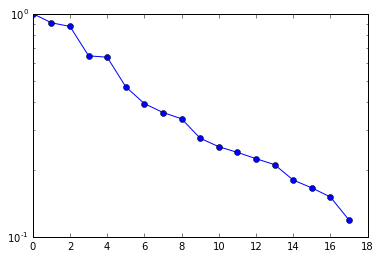

In [23]:
if simul_PS_control==True and simul_FDSP_control==True:
    
    UU, ss, VV = np.linalg.svd(D_PIST, full_matrices=False)
    plt.semilogy(ss/np.max(ss), 'o-')

In [24]:
if simul_PS_control==True and simul_FDSP_control==True:

    R_PIST1 = np.linalg.pinv(D_PIST, rcond=1e-2)
    R_PIST = np.zeros((20,ps.get_measurement_size()))
    R_PIST[0:18,:] = R_PIST1

# Initialize SH AGWS sensors

# Performance Evaluation Initialization

### On-axis performance evaluation

--> WF RMS on-axis: 0.76 nm wf RMS


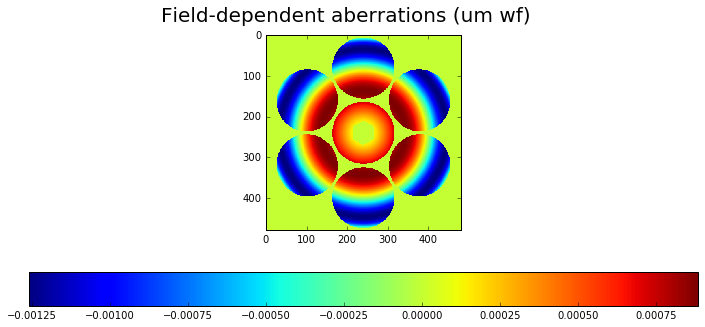

In [25]:
# Initialize on-axis star for performance evaluation
ongs = ceo.Source("R", zenith=0., azimuth=0.,
              rays_box_size=D, rays_box_sampling=nPx, rays_origin=[0.0,0.0,25])
gmt.reset()
ongs.reset()
gmt.propagate(ongs)
ph_fda_on = ongs.phase.host(units='micron')
on_rms0 = ongs.wavefront.rms()*1e9
print '--> WF RMS on-axis: %3.2f nm wf RMS'%on_rms0
seg_pist_onaxis_ref = ongs.piston(where='segments', units_exponent=-9)

if VISU == True:
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    fig.suptitle('Field-dependent aberrations (um wf)', fontsize=20)
    imm = ax.imshow(ph_fda_on, interpolation='None')
    fig.colorbar(imm, orientation='horizontal', shrink=0.6)
    
# On-axis projection of segment shapes onto Zernikes
if eval_perf_modal==True:
    proj_radial_order= np.max( (8, gmt.M1.zernike.max_n+1, gmt.M2.zernike.max_n+1) )
    Zobj = ceo.ZernikeS(proj_radial_order)
    Zobj.fitting_init(ongs)

### Off-axis (Science FoV) performance evaluation

In [25]:
 eval_perf_field = False

In [28]:
#Initialize asterism for performance evaluation in the science field
if eval_perf_field == True:
    
    sfx = np.arange(-45.,55.,22.5) # in arcsec
    sfy = np.arange(-45.,55.,22.5) # in arcsec
    sfxx, sfyy = np.meshgrid(sfx, sfy)
    sf_zenith_angle = np.sqrt(sfxx**2 + sfyy**2) * ceo.constants.ARCSEC2RAD
    sf_azimuth_angle = np.arctan2(sfyy,sfxx)

    sfgs = ceo.Source("R",zenith=sf_zenith_angle.ravel(),azimuth=sf_azimuth_angle.ravel(),#*math.pi/180,
                      rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

    if VISU == True:
        fig,ax1 = plt.subplots()
        fig.set_size_inches((4,4))
        ax1.plot(sfxx,sfyy, '*', markersize=10)
        ax1.set_xlim([-100,100])
        ax1.set_ylim([-100,100])
        ax1.grid()

In [29]:
# Field aberrations in the off-axis performance directions (sfgs)
if eval_perf_field == True:
    sfgs.reset()
    gmt.propagate(sfgs)
    sf_rms0 = sfgs.wavefront.rms()*1e9
    print '--> max WF RMS at the edge of the field: %3.2f nm WF RMS'%np.max(sf_rms0)

    if VISU == True:
        fig, ax2 = plt.subplots()
        fig.set_size_inches((5,4))
        contp = ax2.contourf(sfx, sfy, sf_rms0.reshape(len(sfx),-1))
        clb = fig.colorbar(contp, ax=ax2)
        ax2.grid()
        ax2.tick_params(labelsize=12)
        ax2.set_xlabel('field angle [arcsec]', fontsize=15)
        clb.set_label('nm WF RMS', fontsize=15)
        clb.ax.tick_params(labelsize=12)

In [30]:
if eval_perf_field == True:
    sf_pist0 = sfgs.piston(where='segments', units_exponent=-9)

    if VISU == True:
        fig, ax2 = plt.subplots()
        fig.set_size_inches((5,4))
        contp = ax2.contourf(sfx, sfy, np.std(sf_pist0, axis=1).reshape(len(sfx),-1))
        clb = fig.colorbar(contp, ax=ax2)
        ax2.grid()
        ax2.tick_params(labelsize=12)
        ax2.set_xlabel('field angle [arcsec]', fontsize=15)
        clb.set_label('nm WF', fontsize=15)
        clb.ax.tick_params(labelsize=12)

# Closed-loop simulation initialization

### INITIAL SCRAMBLE

Initial M1 segment TT scramble RMS [mas]: 1500.00
Initial M1 segment TT scramble mean value [mas]: 0.00


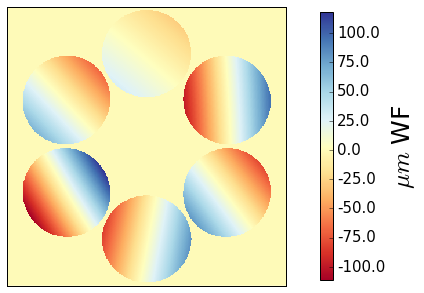

In [88]:
# Reset before starting
if simul_onaxis_AO==True:
    gs.reset()
if simul_SPS==True:
    gsps.reset()
ongs.reset()
gmt.reset()

# Apply a known Tilt to a particular segment on M1
M1RotVecInit = np.array([  #arcsec
            [0,0,0] ,  # 200e-3
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]], dtype='float32') * math.pi/180/3600

# Apply a known segment piston/translation to a particular segment on M1
M1TrVecInit = np.array([  # meters surf
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]], dtype='float32')


# Apply a known Tilt to a particular segment on M2
M2RotVecInit = np.array([  #arcsec
            [0,0,0] ,
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]], dtype='float32') * math.pi/180/3600

# Apply a known segment piston/translation to a particular segment on M2
M2TrVecInit = np.array([  # meters surf
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]], dtype='float32')

# Initial Segment TT Scramble
if scramble_tt==True:
    TTscramble = np.float32(np.random.normal(loc=0.0, scale=1, size=12))
    TTscramble *= tt_scramble_rms*(math.pi/180/3600)/np.std(TTscramble)
    TTscramble -= np.mean(TTscramble)
    
    """TTscramble = np.array([ -1.75567607e-07,  -3.92353201e-07,  -3.31998194e-07,
         1.23213044e-06,   7.21566380e-08,   1.17542027e-06,
        -1.53068822e-06,   1.27538101e-07,   6.87605393e-07,
        -2.37202329e-07,  -4.88611761e-07,  -1.38429471e-07], dtype='float32')"""
    
    M1RotVecInit[0:6,0:2] += TTscramble.reshape((6,2))
    print "Initial M1 segment TT scramble RMS [mas]: %0.2f"%(np.std(TTscramble)*ceo.constants.RAD2MAS)
    print "Initial M1 segment TT scramble mean value [mas]: %0.2f"%(np.mean(TTscramble)*ceo.constants.RAD2MAS)

# Initial Segment Piston Scramble
if scramble_pist==True:
    pistscramble = np.float32(np.random.normal(loc=0.0, scale=1, size=7))
    pistscramble *= pist_scramble_rms/np.std(pistscramble)
    pistscramble -= np.mean(pistscramble)
    pistscramble -= pistscramble[6]
    
    """pistscramble = np.array([ -3.25938601e-07,  -1.26658892e-06,   1.30272156e-06,
         2.35193511e-07,  -1.64358767e-06,  -1.52229950e-06,
         0.00000000e+00], dtype='float32')"""
    
    M1TrVecInit[:,2] += pistscramble
    print "Initial segment piston scramble RMS [micron]: %0.2f"%(np.std(pistscramble)*1e6)
    print "Initial segment piston scramble mean value [micron]: %0.2f"%(np.mean(pistscramble)*1e6)

### Set GMT M1 and M2 rigid-body scrambles
for idx in range(7): gmt.M1.update(origin=M1TrVecInit[idx,:].tolist(),
                                   euler_angles=M1RotVecInit[idx,:].tolist(),
                                   idx=idx+1)

for idx in range(7): gmt.M2.update(origin=M2TrVecInit[idx,:].tolist(),
                                   euler_angles=M2RotVecInit[idx,:].tolist(),
                                   idx=idx+1)


"""# Apply a Zernike vector to a particular segment on M1
mysegId = 2
a_M1 = np.zeros(gmt.M1.zernike.n_mode)   #zernike coeffs, from piston Z1 to n_zern
#a_M1[10] = 250e-9      # m RMS surf
gmt.M1.zernike.a[mysegId-1,:] = a_M1
#for mmmm in range(6): gmt.M1.zernike.a[mmmm,:] = a_M1
gmt.M1.zernike.update()"""

#M2gTTVecInit = np.array((50e-3,0)) * ceo.constants.ARCSEC2RAD
#gmt.M2.global_tiptilt(M2gTTVecInit[0],M2gTTVecInit[1])

if VISU==True:
    ongs.reset()
    gmt.propagate(ongs)
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    imm = ax.imshow(ongs.phase.host(units='micron')-ph_fda_on, interpolation='None',cmap='RdYlBu',origin='lower')
    ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
    clb.set_label('$\mu m$ WF', fontsize=25)
    clb.ax.tick_params(labelsize=15)
    ongs.reset()

### INIT VARIABLES AND ALLOCATE MEMORY FOR RESULTS

In [90]:
totSimulIter = int(totSimulTime/Tsim)
timeVec = np.arange(totSimulIter)*Tsim

if simul_SPS==True:
    sps_exp_count = 0
    sps_exp_count_max = int(exposureTime/Tsim)
    sps_sampl_count = 0
    sps_sampl_count_max = int(samplingTime/exposureTime)
    kk = 1 # to keep the count of PS/FDSP commands applied.
    ps.camera.reset_rng(sps_seed)

    if eval_perf_sps==True:
        seg_pist_sps_iter = np.zeros((N_GS_PS,7,totSimulIter))

    SPSmeas_iter = np.zeros((N_GS_PS*12,sps_sampl_iter+1))
    SPSfft_images = np.zeros((ps.camera.N_PX_IMAGE,ps.camera.N_PX_IMAGE,N_GS_PS*12,sps_sampl_iter+1))
    
M1TrVec  = M1TrVecInit  #np.zeros((7,3))
M1RotVec = M1RotVecInit
M2TrVec  = M2TrVecInit
M2RotVec = M2RotVecInit

if simul_PS_control==True:
    M1PSresiter = np.zeros((7,sps_sampl_iter+1))
    M1PSresiter[:,0] = M1TrVec[:,2] # kk=0

if simul_FDSP_control==True:
    M1TTresiter = np.zeros((7,2,sps_sampl_iter+1))
    M1TTresiter[:,:,0] = M1RotVec[:,0:2]  # kk=0

if simul_onaxis_AO==True:
    a_M2      = np.zeros(nall)
    a_M2_iter = np.zeros((nall,totSimulIter))
    if AOtype=='NGAOish':
        myAOest1 = np.zeros(nall+7)  #7x2 segments TTs + 7 outer segment pistons
        M2PSiter = np.zeros((7,totSimulIter))
    elif AOtype=='LTAOish':
        myAOest1 = np.zeros(nall)  #delta command buffer
        
        
if eval_perf_onaxis==True:
    wfe_gs_iter      = np.zeros(totSimulIter)
    seg_pist_onaxis_iter  = np.zeros((7,totSimulIter))
    seg_wfe_onaxis_iter = np.zeros((7,totSimulIter))
    if simul_turb==True:
        wfe_gs_tur_iter = np.zeros(totSimulIter)
    if eval_perf_modal==True:
        seg_aRes_gs_iter = np.zeros((Zobj.n_mode,7,totSimulIter))
        if simul_turb==True:
            seg_aTur_gs_iter = np.zeros((Zobj.n_mode,7,totSimulIter))

if eval_perf_field == True:
    wfe_sfgs_iter  = np.zeros((sfgs.N_SRC, totSimulIter))
    pist_sfgs_iter = np.zeros((sfgs.N_SRC, totSimulIter))

elapsedTime = np.zeros(totSimulIter)

print 'Total simulation time [s]: %4.3f'%(totSimulTime)
if simul_SPS == True:
    print '  DFS Sampling time  [ms]: %4.2f'%(samplingTime*1e3)
    print '  DFS Exposure time  [ms]: %4.2f'%(exposureTime*1e3)
print 'Simulation time step [ms]: %4.2f'%(Tsim*1e3)

Total simulation time [s]: 0.300
  DFS Sampling time  [ms]: 30.00
  DFS Exposure time  [ms]: 6.00
Simulation time step [ms]: 2.00


### CLOSE THE LOOP!!

 iter: 149/150, ET: 491.30, seg piston [nm WF RMS] on-axis: 0.0

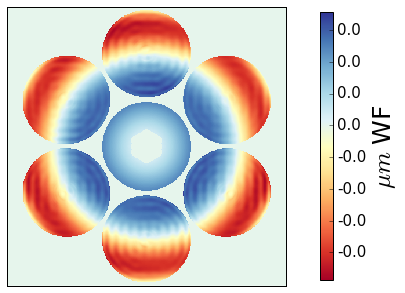

In [91]:
if simul_SPS==True: ps.reset()

for jj in range(totSimulIter):
    #print("\nElapsed time:%3.3f"%((jj+1)*Tsim))
    tid.tic()
    if simul_SPS==True: gsps.reset()
    if simul_SH==True:  gs.reset()
    if eval_perf_onaxis==True: ongs.reset()
    if eval_perf_field==True: sfgs.reset()

    #----- Update Turbulence --------------------------------------------
    if simul_turb == True:
        if simul_SPS==True:
            atm.ray_tracing(gsps, p,nPx,p,nPx, jj*Tsim)
        if simul_onaxis_AO==True:
            atm.ray_tracing(  gs, p,nPx,p,nPx, jj*Tsim)
        if eval_perf_onaxis==True:
            atm.ray_tracing(ongs, p,nPx,p,nPx, jj*Tsim)
            wfe_gs_tur_iter[jj] = ongs.wavefront.rms()
            if eval_perf_modal==True:
                PhaseTur = ongs.phase.host(units='nm')-ph_fda_on*1e3
                seg_aTur_gs_iter[:,:,jj] = Zobj.fitting(PhaseTur)
        if eval_perf_field==True:
            atm.ray_tracing(sfgs, p,nPx,p,nPx, jj*Tsim)
            
    #----- Update M1 positions -------------------------------------
    for idx in range(7): gmt.M1.update(origin =  M1TrVec[idx,:].tolist(),
                                 euler_angles = M1RotVec[idx,:].tolist(),
                                 idx = idx+1)
        
    #---- segment KL correction (on M2)
    if simul_onaxis_AO==True:
        gmt.M2.modes.a[:,z_first_mode:] -= myAOest1[0:nall].reshape((7,-1))
        gmt.M2.modes.update()
        if AOtype=='NGAOish':
            gmt.M2.motion_CS.origin[:,2] -= myAOest1[nall:]
            gmt.M2.motion_CS.update()


    #----- On-axis WFS measurement and correction -----------------------
    if simul_onaxis_AO==True:
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
        slopevec = wfs.get_measurement()
        
        if AOtype=='NGAOish':
            onpsvec =  onps.piston(gs).ravel() - onps_signal_ref
            AOmeasvec = np.concatenate((slopevec, onpsvec))
        elif AOtype=='LTAOish':
            AOmeasvec = slopevec
        myAOest1 = gAO*np.dot(R_AO, AOmeasvec)
        
        a_M2_iter[:,jj] = a_M2
        a_M2 -= myAOest1[0:nall]
        if AOtype=='NGAOish':
            M2PSiter[:,jj] = M2TrVec[:,2]            
            M2TrVec[:,2] -= myAOest1[nall:]

    #----- Performance evaluation ---------------------------------
    if eval_perf_onaxis==True:
        gmt.propagate(ongs)
        wfe_gs_iter[jj] = ongs.wavefront.rms()
        seg_pist_onaxis_iter[:,jj] = ongs.piston(where='segments', units_exponent=-9) - seg_pist_onaxis_ref
        seg_wfe_onaxis_iter[:,jj] = ongs.phaseRms(where='segments', units_exponent=-9)

        if eval_perf_modal==True:
            PhaseRes = ongs.phase.host(units='nm')-ph_fda_on*1e3
            seg_aRes_gs_iter[:,:,jj] = Zobj.fitting(PhaseRes)

    if eval_perf_field==True:
        gmt.propagate(sfgs)
        wfe_sfgs_iter[:,jj]  = sfgs.wavefront.rms()
        pist_sfgs_iter[:,jj] = np.std(sfgs.piston(where='segments', units_exponent=-9) - sf_pist0, axis=1)

    #----- Segment Piston Sensors measurement and correction -------------
    if simul_SPS==True:
        gmt.propagate(gsps)
        
        if sps_sampl_count >= sps_sampl_delay:
            #print("Fringe Generation at %4.3f s:"%((jj+1)*Tsim))
            ps.propagate(gsps)
        
        if eval_perf_sps==True:
            seg_pist_sps_iter[:,:,jj] = gsps.piston(where='segments', units_exponent=-9) - seg_pist_sps_ref

        if sps_exp_count == sps_exp_count_max-1:
            
            if sps_sampl_count >= sps_sampl_delay:
                #print("Reading Out SPS detectors at %4.3f s:"%((jj+1)*Tsim))

                #--- Read-out the detector
                if simul_phot==True:
                    if simul_bkgd==False:
                        ps.camera.readOut(exposureTime,RONval)
                    else: ps.readOut(exposureTime,RONval,bkgd_mag)
            
                #--- Compute and integrate FFTlet images:
                ps.fft()
                
            ps.camera.reset()
            sps_exp_count = 0
            #print("SPS exposure completed at %3.1f ms"%((jj+1)*Tsim*1e3))

            #--- Compute SPS signals:
            if sps_sampl_count == sps_sampl_count_max-1:
                #print("Applying SPP/FDSP command at %4.3f s:"%((jj+1)*Tsim))
                ps.process()
                SPSmeas = ps.measurement - SPSmeas_ref
                SPSfft_images[:,:,:,kk] = ps.get_data_cube(data_type='fftlet')
                SPSmeas_iter[:,kk] = SPSmeas
                
                #--- segment piston AND FDSP control:
                if simul_PS_control==True and simul_FDSP_control==True:
                    PISTvec = np.dot(R_PIST, SPSmeas)
                    myPSest1 = gPS * PISTvec[0:6]
                    M1TrVec[0:6,2] -= myPSest1
                    #myPSest1 = gPS * PISTvec[0:7]
                    #M1TrVec[:,2] -= myPSest1
                    M1PSresiter[:,kk]   = M1TrVec[:,2]
                    #M1PSresiter[0:6,kk] = PISTvec[0:6]  #To save SPP estimates without applying them!
                    myFDSPest1 = gFDSP * PISTvec[6:].reshape((7,2))
                    #myFDSPest1 = gFDSP * PISTvec[7:].reshape((7,2))
                    M1RotVec[:,0:2] -= myFDSPest1
                    M1TTresiter[:,:,kk] = M1RotVec[:,0:2]

                #--- ONLY segment piston control:
                elif simul_PS_control==True:
                    PISTvec = np.dot(R_M1_PS, SPSmeas)
                    myPSest1 = gPS * PISTvec
                    M1TrVec[0:6,2] -= myPSest1
                    M1PSresiter[:,kk]   = M1TrVec[:,2]
                    #M1PSresiter[0:6,kk] = myPSest1 #Temporary line to keep track of estimates without applying them.

                #--- ONLY FDSP control:
                elif simul_FDSP_control==True:
                    PISTvec = np.dot(R_FDSP, SPSmeas)
                    myFDSPest1 = gFDSP * PISTvec.reshape((6,2))
                    M1RotVec[0:6,0:2] -= myFDSPest1
                    M1TTresiter[:,:,kk] = M1RotVec[:,0:2]

                #if simul_PS_control==True:
                #    sys.stdout.write("\nseg piston RMS [microns]: %0.3f\n"%(np.std(M1PSresiter[:,kk])*1e6))

                ps.fftlet.reset()
                sps_sampl_count = 0
                sps_exp_delay_count = 0
                kk += 1
                #print("SPS command applied at %3.1f ms"%((jj+1)*Tsim*1e3))
            else: sps_sampl_count += 1
        else: sps_exp_count += 1

    tid.toc()
    elapsedTime[jj] = tid.elapsedTime
    sys.stdout.write("\r iter: %d/%d, ET: %.2f, seg piston [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, np.std(seg_pist_onaxis_iter[:,jj])))
    sys.stdout.flush()   
    
if VISU == True:
    #ongs.reset()
    #gmt.propagate(ongs)
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    imm = ax.imshow(ongs.phase.host(units='micron'), interpolation='None',cmap='RdYlBu',origin='lower')#, vmin=-8, vmax=8)
    ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off',
                   right='off', left='off', labelleft='off')
    clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
    clb.set_label('$\mu m$ WF', fontsize=25)
    clb.ax.tick_params(labelsize=15)
    #ongs.reset()

In [92]:
tosave = dict(D=D, nPx=nPx, Tsim=Tsim, totSimulTime=totSimulTime, simul_turb=simul_turb,
        simul_onaxis_AO=simul_onaxis_AO, simul_PS_control=simul_PS_control,
        simul_FDSP_control=simul_FDSP_control, simul_SH=simul_SH, simul_SPS=simul_SPS, 
        elapsedTime=elapsedTime, scramble_tt=scramble_tt, scramble_pist=scramble_pist, CEO_git_commit=CEO_git_commit)

if simul_turb == True:
    tosave.update(dict(r0=r0, L0=L0, atm_fname=atm_fname, atm_seed=atm_seed))

if simul_SPS == True:
    tosave.update(dict(SPStype=SPStype, asterism_type=asterism_type, N_GS_PS=N_GS_PS,
        zenith=zenith_angle_agws, azimuth=azimuth_angle_agws,
        band=band, mag=mag, bkgd_mag=bkgd_mag,sps_fov=sps_fov, sps_dispersion=sps_dispersion,
        sps_mask_size=sps_mask_size, RONval=RONval, sps_seed=sps_seed, simul_phot=simul_phot, simul_bkgd=simul_bkgd,
        SPSmeas_ref=SPSmeas_ref, exposureTime=exposureTime, samplingTime=samplingTime, sps_sampl_delay=sps_sampl_delay,
        throughput=throughput, lobe_detection=lobe_detection, nyquist_factor=nyquist_factor,
        sps_sampl_iter=sps_sampl_iter, SPSmeas_iter=SPSmeas_iter, SPSfft_images=SPSfft_images))
    if asterism_type =='Besancon_GP': tosave['asterism_id']=asterism_id
    if eval_perf_sps == True: tosave['seg_pist_sps_iter']=seg_pist_sps_iter

if simul_SH == True:
    tosave.update(dict(sh_SA=nLenslet, sh_npix=n, SHtype=SHtype, sh_thr=sh_thr))
    if SHtype == 'diff':
        tosave['sh_fov'] = sh_fov

if simul_onaxis_AO == True:
    tosave.update(dict(AOtype=AOtype, gAO=gAO, onaxis_AO_modes=onaxis_AO_modes, a_M2_iter=a_M2_iter))
    if onaxis_AO_modes==u'zernikes': tosave['M2_radial_order']=M2_radial_order
    elif onaxis_AO_modes==u'Karhunen-Loeve': tosave['M2_n_modes']=M2_n_modes
    if AOtype=='NGAOish': tosave['M2PSiter']=M2PSiter
        
if simul_PS_control == True:
    tosave.update(dict(gPS=gPS, M1PSresiter=M1PSresiter))

if simul_FDSP_control == True:
    tosave.update(dict(gFDSP=gFDSP, M1TTresiter=M1TTresiter))

if eval_perf_onaxis == True:
    tosave.update(dict(wfe_gs_iter=wfe_gs_iter, seg_pist_onaxis_iter=seg_pist_onaxis_iter,
                      seg_wfe_onaxis_iter=seg_wfe_onaxis_iter))
    if simul_turb == True: tosave['wfe_gs_tur_iter']=wfe_gs_tur_iter

    if eval_perf_modal == True:
        tosave['seg_aRes_gs_iter']=seg_aRes_gs_iter
        if simul_turb == True: tosave['seg_aTur_gs_iter']=seg_aTur_gs_iter

if eval_perf_field == True:
    #tosave['wfe_sfgs_iter'] = wfe_sfgs_iter
    #tosave['wfe_sfgs_ref'] = sf_rms0
    tosave['pist_sfgs_iter'] = pist_sfgs_iter
    tosave['pist_sfgs_ref'] = sf_pist0

if scramble_tt == True:
    tosave.update(dict(tt_scramble_rms=tt_scramble_rms, TTscramble=TTscramble))

if scramble_pist == True:
    tosave.update(dict(pist_scramble_rms=pist_scramble_rms, pistscramble=pistscramble))

In [49]:
#---- Save the results file!
#now = datetime.datetime.now()
#save_dir = './'
#filename=save_dir+'SPS'+str(int(alpha_ps/60))+'_'+clcalib+'_mag'+str(int(mag))+'_Turb'+str(atm_seed)+'_Noise'+str(sps_seed)+'_Texp'+str(int(exposureTime*1e3))+'ms'+'_Ts'+str(int(samplingTime*1e3))+'ms.npz'
#filename=save_dir+now.strftime("%Y%m%d-%H%M")+'.npz'
filename='simul_results.npz'
np.savez_compressed(filename, **tosave)

Final WFE [nm RMS]: 65.4
Equivalent SR in K band: 0.9657


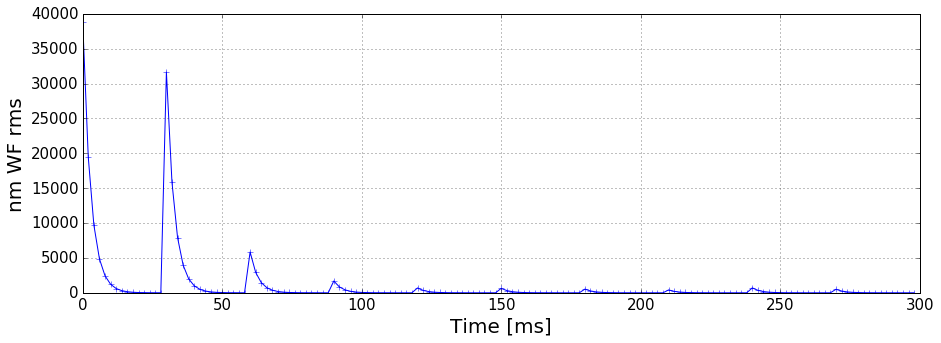

In [93]:
#### on-axis WFE vs. iteration number
if VISU == True and eval_perf_onaxis==True:
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)
    ax.plot(timeVec*1e3, wfe_gs_iter*1e9, '-+')
    ax.grid()
    ax.set_xlabel('Time [ms]', fontsize=20)
    ax.set_ylabel('nm WF rms', fontsize=20)
    ax.tick_params(labelsize=15)

    wfe_final = np.mean(wfe_gs_iter[100:])
    print ('Final WFE [nm RMS]: %3.1f'%(wfe_final*1e9))
    print ('Equivalent SR in K band: %1.4f'%(np.exp(-(wfe_final*2*np.pi/2.2e-6)**2)))

seg piston [nm WF RMS] on-axis: 3.3


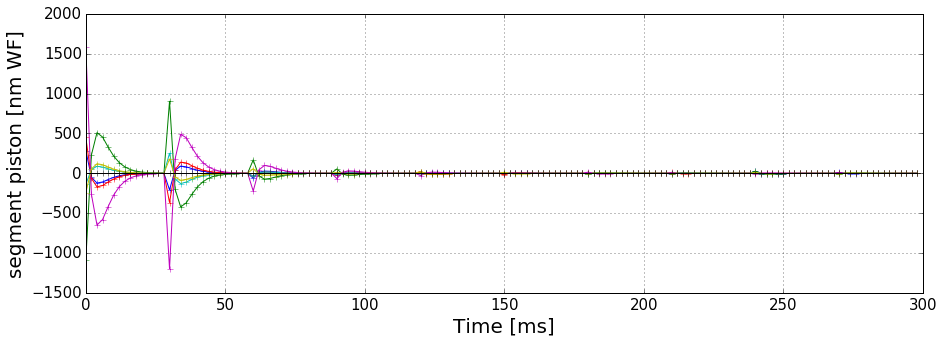

In [94]:
#### on-axis segment Piston vs. iteration number
if VISU == True and eval_perf_onaxis==True:
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)
    ax.plot(timeVec*1e3, seg_pist_onaxis_iter.T, '-+')
    ax.grid()
    ax.set_xlabel('Time [ms]', fontsize=20)
    ax.set_ylabel('segment piston [nm WF]', fontsize=20)
    ax.tick_params(labelsize=15)

    print "seg piston [nm WF RMS] on-axis: %0.1f"%(np.std(seg_pist_onaxis_iter[:,100:]))

Final WFE [nm RMS]: 55.0
Equivalent SR in K band: 0.9756


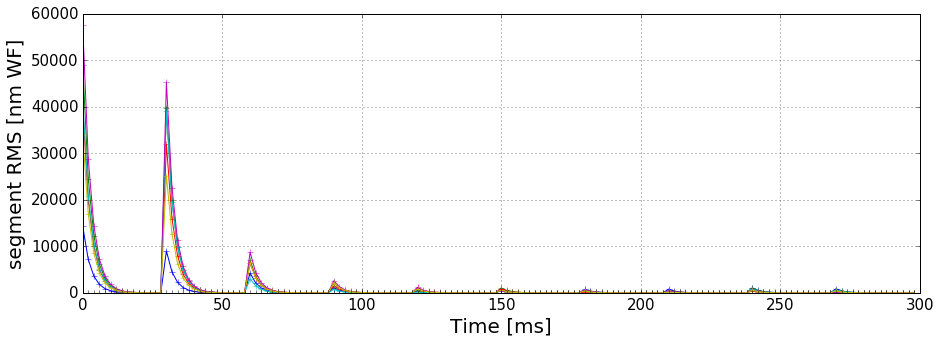

In [95]:
#### on-axis segment WFE vs. iteration number
if VISU == True and eval_perf_onaxis==True:
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)
    ax.plot(timeVec*1e3, seg_wfe_onaxis_iter.T, '-+')
    ax.grid()
    ax.set_xlabel('Time [ms]', fontsize=20)
    ax.set_ylabel('segment RMS [nm WF]', fontsize=20)
    ax.tick_params(labelsize=15)

    wfe_final = np.mean(seg_wfe_onaxis_iter[:,100:])
    print ('Final WFE [nm RMS]: %3.1f'%(wfe_final))
    print ('Equivalent SR in K band: %1.4f'%(np.exp(-(wfe_final*2*np.pi/2200.0)**2)))

Final M1 final piston (Tz) values [nm WF]:
[ 0.  0.  0.  0.  0.  0.  0.]
-----
Final M2 final piston (Tz) values [nm WF]:
[ 3.738 -2.829  5.147  2.107  4.655  3.418 -0.   ]


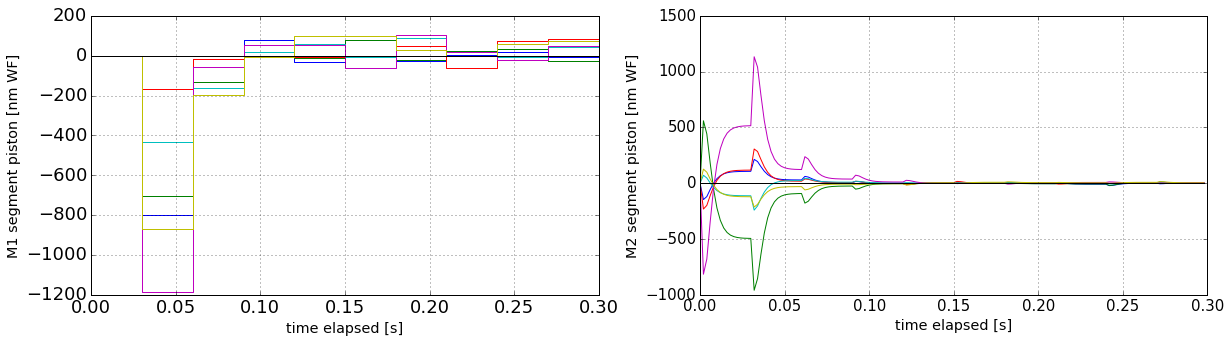

In [96]:
#### Residual segment piston analysis
print 'Final M1 final piston (Tz) values [nm WF]:'
print np.array_str(gmt.M1.motion_CS.origin[:,2]*1e9*2, precision=3, suppress_small=True)
print '-----'
print 'Final M2 final piston (Tz) values [nm WF]:'
print np.array_str(gmt.M2.motion_CS.origin[:,2]*1e9*2, precision=3, suppress_small=True)

if VISU == True:
    if simul_PS_control==True or simul_FDSP_control==True:
        timeCorVec = np.arange(sps_sampl_iter+1)*samplingTime
    else: timeCorVec = timeVec
    
    if simul_onaxis_AO==True and AOtype=='NGAOish':
        f1, (ax1,ax2) = plt.subplots(ncols=2)
        f1.set_size_inches(20,5)
    else:
        f1, ax1 = plt.subplots()
        f1.set_size_inches(10,5)
        
    if simul_PS_control==True:
        ax1.plot(timeCorVec, M1PSresiter.T *1e9*2, label='S', drawstyle='steps-post')
        ax1.grid()
        #ax1.set_title('Tz', size='x-large')
        ax1.set_xlabel('time elapsed [s]', size='x-large')
        ax1.set_ylabel('M1 segment piston [nm WF]', size='x-large')
        ax1.tick_params(labelsize=18)
        #ax1.legend()
    elif scramble_pist==True:
        ax1.plot(np.array([0, np.max(timeVec)]), np.array([pistscramble,pistscramble])*1e9*2)
        ax1.grid()
        ax1.set_xlabel('elapsed time [s]',size='x-large')
        ax1.set_ylabel('M1 segment piston [nm WF]', size='x-large')
        ax1.tick_params(labelsize=15)

    if simul_onaxis_AO==True and AOtype=='NGAOish':    
        ax2.plot(timeVec, M2PSiter.T *1e9*2, label='S')
        ax2.grid()
        #ax1.set_title('Tz', size='x-large')
        ax2.set_xlabel('time elapsed [s]', size='x-large')
        ax2.set_ylabel('M2 segment piston [nm WF]', size='x-large')
        ax2.tick_params(labelsize=15)

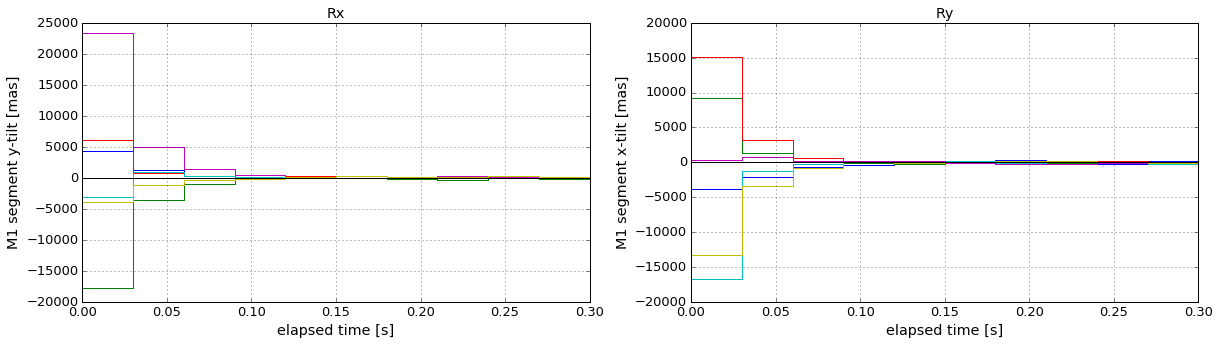

In [97]:
if VISU==True:
    f1, (ax3,ax4) = plt.subplots(ncols=2)
    f1.set_size_inches(20,5)

    if simul_FDSP_control==True :
        timeCorVec = np.arange(sps_sampl_iter+1)*samplingTime
        ax3.plot(timeCorVec, M1TTresiter[:,0,:].T *ceo.constants.RAD2MAS*8, drawstyle='steps-post')
        ax3.grid()
        ax3.set_title('Rx', size='x-large')
        ax3.set_xlabel('elapsed time [s]',size='x-large')
        ax3.set_ylabel('M1 segment y-tilt [mas]', size='x-large')
        ax3.tick_params(labelsize=13)
    #    ax3.set_xlim([0,60])


        ax4.plot(timeCorVec, M1TTresiter[:,1,:].T *ceo.constants.RAD2MAS*8, drawstyle='steps-post')
        ax4.grid()
        ax4.set_title('Ry', size='x-large')
        ax4.set_xlabel('elapsed time [s]', size='x-large')
        ax4.set_ylabel('M1 segment x-tilt [mas]', size='x-large')
        ax4.tick_params(labelsize=13)
    #    ax4.set_xlim([0,60])

    elif scramble_tt==True :
        TTscr = TTscramble.reshape((6,2))
        ax3.plot([0, max(timeVec)], np.array([TTscr[:,0],TTscr[:,0]])*ceo.constants.RAD2MAS*8)
        ax3.grid()
        #ax3.set_title('Rx', size='x-large')
        ax3.set_xlabel('elapsed time [s]',size='x-large')
        ax3.set_ylabel('M1 segment y-tilt [mas]', size='x-large')
        ax3.tick_params(labelsize=13)
    #    ax3.set_xlim([0,60])

        ax4.plot([0, max(timeVec)], np.array([TTscr[:,1],TTscr[:,1]])*ceo.constants.RAD2MAS*8)
        ax4.grid()
        #ax4.set_title('Rx', size='x-large')
        ax4.set_xlabel('elapsed time [s]',size='x-large')
        ax4.set_ylabel('M1 segment y-tilt [mas]', size='x-large')
        ax4.tick_params(labelsize=13)
    #    ax4.set_xlim([0,60])

In [83]:
if simul_FDSP_control==True:
    if scramble_tt==True: 
        FDSP_convergence_sampl_niter = 5
    else:
        FDSP_convergence_sampl_niter = 1
    FDSP_convergence_niter = np.int32(FDSP_convergence_sampl_niter * samplingTime / Tsim)
 
    #print FDSP_convergence_niter
    print "M1 x-tilt residual [mas RMS]"
    print np.std(M1TTresiter[:,1,FDSP_convergence_sampl_niter:].T)*ceo.constants.RAD2MAS #* (30/7)
    print "M1 y-tilt residual [mas RMS]"
    print np.std(M1TTresiter[:,0,FDSP_convergence_sampl_niter:].T)*ceo.constants.RAD2MAS 

M1 x-tilt residual [mas RMS]
15.768325972
M1 y-tilt residual [mas RMS]
15.950344882


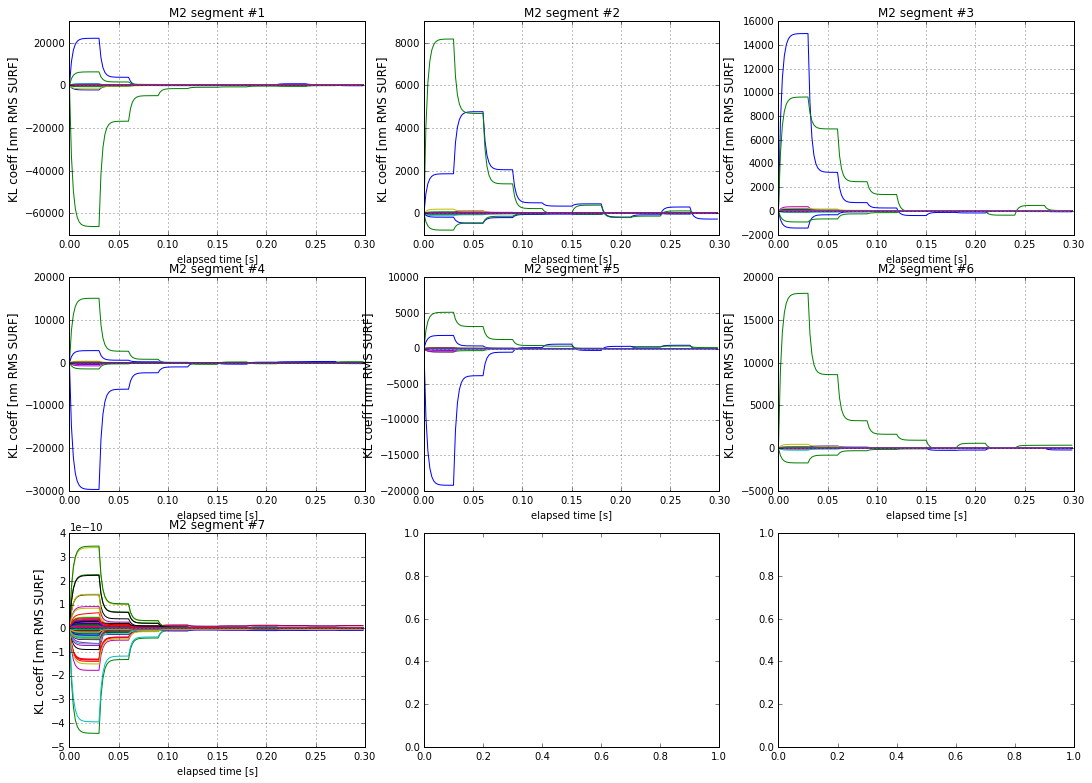

In [84]:
### Residual M2 segment Zernikes
if simul_onaxis_AO==True and VISU==True:
    my_a_M2 = (a_M2_iter.reshape((7,-1,totSimulIter)))
    f1, ax = plt.subplots(ncols=3, nrows=3)
    f1.set_size_inches(18,13)
    for jj in range(7):
        thisax = (ax.ravel())[jj]
        thisax.plot(timeVec, my_a_M2[jj,:,:].T*1e9)
        thisax.grid()
        thisax.set_title('M2 segment #%d'%(jj+1), size='large')
        thisax.set_xlabel('elapsed time [s]')
        thisax.set_ylabel('KL coeff [nm RMS SURF]', size='large')

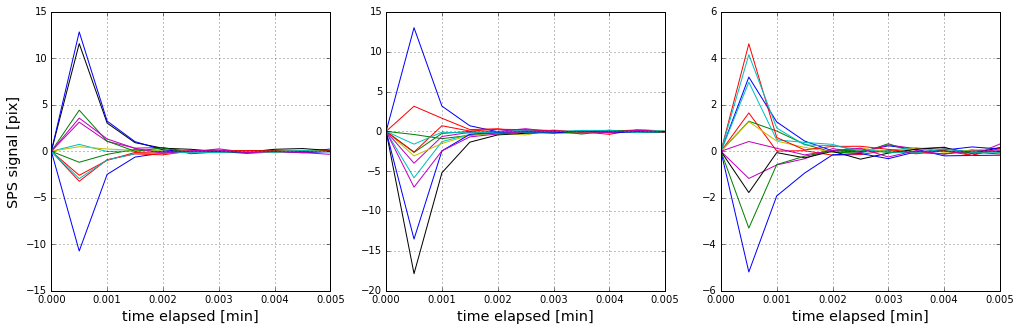

In [85]:
if simul_SPS==True and VISU==True:
    f1, ax = plt.subplots(ncols=gsps.N_SRC)
    f1.set_size_inches(17,5)
    pp=0
    for thisax in ax:
        thisax.plot(timeCorVec/60, SPSmeas_iter[pp*12:(pp+1)*12,:].T)
        thisax.grid()
        thisax.set_xlabel('time elapsed [min]', size='x-large')
        if pp==0: thisax.set_ylabel('SPS signal [pix]', size='x-large')
        thisax.tick_params(labelsize=10)
        pp+=1
        #ax1.set_ylim([-0.3,0.3])

seg piston [nm WF RMS] on PS GSs: 39.0, 84.1, 43.2


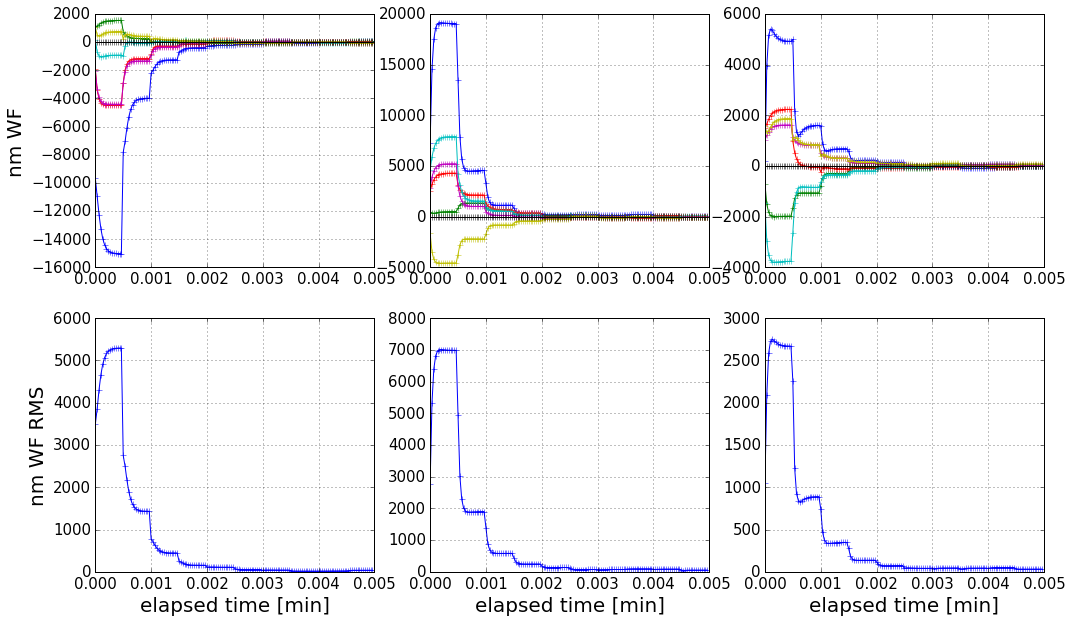

In [86]:
if simul_SPS==True and VISU==True:

    seg_pist_rms_sps_iter = np.std(seg_pist_sps_iter, axis=1)

    #### off-axis segment piston (at the three SPS directions) vs. iteration number 
    fig, ax = plt.subplots(ncols=gsps.N_SRC, nrows=2)
    fig.set_size_inches(17,10)

    for kk in range(N_GS_PS):
        (ax.ravel())[kk].plot(timeVec/60, seg_pist_sps_iter[kk,:,:].T, '-+')
        (ax.ravel())[kk].grid()
        #(ax.ravel())[kk].set_xlabel('elapsed time [min]', fontsize=20)
        if kk==0: (ax.ravel())[kk].set_ylabel('nm WF', fontsize=20)
        (ax.ravel())[kk].tick_params(labelsize=15)

    for kk in range(N_GS_PS):
        (ax.ravel())[kk+N_GS_PS].plot(timeVec/60, seg_pist_rms_sps_iter[kk,:], '-+')
        (ax.ravel())[kk+N_GS_PS].grid()
        (ax.ravel())[kk+N_GS_PS].set_xlabel('elapsed time [min]', fontsize=20)
        if kk==0: (ax.ravel())[kk+N_GS_PS].set_ylabel('nm WF RMS', fontsize=20)
        (ax.ravel())[kk+N_GS_PS].tick_params(labelsize=15)

    print "seg piston [nm WF RMS] on PS GSs: %0.1f, %0.1f, %0.1f"%((np.std(seg_pist_sps_iter[0,:,75:]),
                                                                   np.std(seg_pist_sps_iter[1,:,75:]),
                                                                   np.std(seg_pist_sps_iter[2,:,75:])))

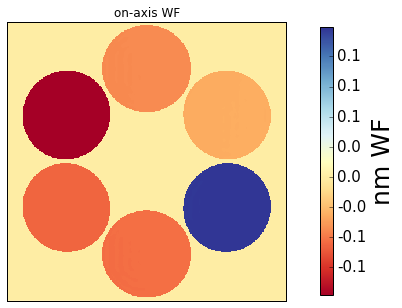

In [41]:
### Show final on-axis residual WF
if VISU == True:
    #ongs.reset()
    #gmt.propagate(ongs)
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    imm = ax.imshow(ongs.phase.host(units='nm')-ph_fda_on*1e3, interpolation='None',cmap='RdYlBu', origin='lower')#, vmin=-1.5, vmax=1.5)
    ax.set_title('on-axis WF')
    ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
    clb.set_label('nm WF', fontsize=25)
    clb.ax.tick_params(labelsize=15)